In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.impute import SimpleImputer
import lightgbm as lgbm
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
import pickle
import re
import os

In [3]:
df = pd.read_csv(os.path.join(os.path.pardir, "data", "laptop_price.csv"), encoding_errors = "ignore")
df.head()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


In [4]:
# drop first inches and id
df.drop(["Inches", "laptop_ID"], axis = 1, inplace = True)

In [5]:
X = df.drop("Price_euros", axis = 1).columns
y = "Price_euros"

In [6]:
df[X].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Company           1303 non-null   object
 1   Product           1303 non-null   object
 2   TypeName          1303 non-null   object
 3   ScreenResolution  1303 non-null   object
 4   Cpu               1303 non-null   object
 5   Ram               1303 non-null   object
 6   Memory            1303 non-null   object
 7   Gpu               1303 non-null   object
 8   OpSys             1303 non-null   object
 9   Weight            1303 non-null   object
dtypes: object(10)
memory usage: 101.9+ KB


In [7]:
def handle_storage_space(x):
    spaces_lst = []
    for val in x.split():
        if "GB" in val or "TB" in val:
            if "TB" in val:
                spaces_lst.append(int(re.findall("\d+", val)[0])*1000)
            else:
                spaces_lst.append(int(re.findall("\d+", val)[0]))
    return sum(spaces_lst)

In [8]:
# data cleaning & preprocessing phase..
df["Ram"] = df["Ram"].apply(lambda x: x[:-2])
df["Ram"] = df["Ram"].astype("int8")
df["Weight"] = df["Weight"].apply(lambda x: x[:-2])
df["Weight"] = df["Weight"].astype("float16")
df["CPU_manufacturer"] = df["Cpu"].apply(lambda x: x.split()[0])
df["CPU_frequency"] = df["Cpu"].apply(lambda x: x.split()[-1])
df["CPU_frequency"] = df["CPU_frequency"].apply(lambda x: x[:-3])
df["CPU_frequency"] = df["CPU_frequency"].astype("float16")
df["CPU_model"] = df["Cpu"].apply(lambda x: x.split()[1:-1])
df["CPU_model"] = df["CPU_model"].apply(lambda x:''.join(val+'-' if idx != len(x)-1 else val for idx, val in enumerate(x)))
width_lst = df["ScreenResolution"].apply(lambda x:int(x.split()[-1].split(sep = "x")[0]) * 0.0264583333).values 
height_lst = df["ScreenResolution"].apply(lambda x:int(x.split()[-1].split(sep = "x")[1]) * 0.0264583333).values
df["screen_area_cm2"] = list(map(lambda x, y: x*y, width_lst, height_lst))
df["is_4K"] = df["ScreenResolution"].apply(lambda x: 1 if "4K Ultra HD" in x else 0)
df["is_touchscreen"] = df["ScreenResolution"].apply(lambda x: 1 if "Touchscreen" in x else 0)
df["is_full_HD"] = df["ScreenResolution"].apply(lambda x: 1 if "Full HD" in x else 0)
df["is_Quad"] = df["ScreenResolution"].apply(lambda x: 1 if "Quad" in x else 0)
df["is_HD+"] = df["ScreenResolution"].apply(lambda x: 1 if "HD+" in x else 0)
df["is_ips_panel"] = df["ScreenResolution"].apply(lambda x: 1 if "IPS Panel" in x else 0)
df["is_retina_display"] = df["ScreenResolution"].apply(lambda x: 1 if "Retina Display" in x else 0)
df["is_ssd"] = df["Memory"].apply(lambda x: 1 if "SSD" in x else 0)
df["is_hdd"] = df["Memory"].apply(lambda x: 1 if "HDD" in x else 0)
df["is_hybrid_storage"] = df["Memory"].apply(lambda x: 1 if "Hybrid" in x else 0)
df["is_flash_storage"] = df["Memory"].apply(lambda x: 1 if "Flash" in x else 0)
df["unique_storage_types"] = df["is_ssd"] + df["is_hdd"] + df["is_hybrid_storage"] + df["is_flash_storage"]
df["total_storage"] = df["Memory"].apply(handle_storage_space)
df["GPU_manufacturer"] = df["Gpu"].apply(lambda x:x.split()[0])
# Drop Raw Data Columns....
df.drop(["ScreenResolution", "Cpu", "Memory", "Gpu"], axis = 1, inplace = True)

In [9]:
df.drop("Product", axis = 1, inplace = True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company               1303 non-null   object 
 1   TypeName              1303 non-null   object 
 2   Ram                   1303 non-null   int8   
 3   OpSys                 1303 non-null   object 
 4   Weight                1303 non-null   float16
 5   Price_euros           1303 non-null   float64
 6   CPU_manufacturer      1303 non-null   object 
 7   CPU_frequency         1303 non-null   float16
 8   CPU_model             1303 non-null   object 
 9   screen_area_cm2       1303 non-null   float64
 10  is_4K                 1303 non-null   int64  
 11  is_touchscreen        1303 non-null   int64  
 12  is_full_HD            1303 non-null   int64  
 13  is_Quad               1303 non-null   int64  
 14  is_HD+                1303 non-null   int64  
 15  is_ips_panel         

In [11]:
company_enc = OrdinalEncoder()
type_enc = OrdinalEncoder()
os_enc = OrdinalEncoder()
cpu_manfacturer_enc = OrdinalEncoder()
cpu_model_enc = OrdinalEncoder()
gpu_manfacturer_enc = OrdinalEncoder()

In [12]:
# copy the dataframe.
pre_df = df.copy()

In [13]:
pre_df["Company"] = company_enc.fit_transform(pre_df["Company"].values.reshape(-1, 1))
pre_df["TypeName"] = company_enc.fit_transform(pre_df["TypeName"].values.reshape(-1, 1))
pre_df["OpSys"] = company_enc.fit_transform(pre_df["OpSys"].values.reshape(-1, 1))
pre_df["CPU_manufacturer"] = company_enc.fit_transform(pre_df["CPU_manufacturer"].values.reshape(-1, 1))
pre_df["CPU_model"] = company_enc.fit_transform(pre_df["CPU_model"].values.reshape(-1, 1))
pre_df["GPU_manufacturer"] = company_enc.fit_transform(pre_df["GPU_manufacturer"].values.reshape(-1, 1))

In [14]:
# categorical columns: Company:0, TypeName:1, OpSys:3, CPU_manufacturer:6, CPU_model:8, 
# is_4K':10, 'is_touchscreen':11, 'is_full_HD':12, 'is_Quad':13, 'is_HD+':14,
#'is_ips_panel':15, 'is_retina_display':16, 'is_ssd':17, 'is_hdd':18,
#'is_hybrid_storage':19, 'is_flash_storage':20, 'unique_storage_types:21, GPU_manufacturer:23
cat_idx = [0, 1, 3, 5, 7, 22]

In [15]:
cat_cols_idx = [0, 1, 3, 5, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22]

In [16]:
X = pre_df.drop("Price_euros", axis = 1)
y = pre_df["Price_euros"]
mi_scores = mutual_info_regression(X, y, discrete_features=cat_cols_idx)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]),
 [Text(0, 0, 'Company'),
  Text(1, 0, 'TypeName'),
  Text(2, 0, 'Ram'),
  Text(3, 0, 'OpSys'),
  Text(4, 0, 'Weight'),
  Text(5, 0, 'CPU_manufacturer'),
  Text(6, 0, 'CPU_frequency'),
  Text(7, 0, 'CPU_model'),
  Text(8, 0, 'screen_area_cm2'),
  Text(9, 0, 'is_4K'),
  Text(10, 0, 'is_touchscreen'),
  Text(11, 0, 'is_full_HD'),
  Text(12, 0, 'is_Quad'),
  Text(13, 0, 'is_HD+'),
  Text(14, 0, 'is_ips_panel'),
  Text(15, 0, 'is_retina_display'),
  Text(16, 0, 'is_ssd'),
  Text(17, 0, 'is_hdd'),
  Text(18, 0, 'is_hybrid_storage'),
  Text(19, 0, 'is_flash_storage'),
  Text(20, 0, 'unique_storage_types'),
  Text(21, 0, 'total_storage'),
  Text(22, 0, 'GPU_manufacturer')])

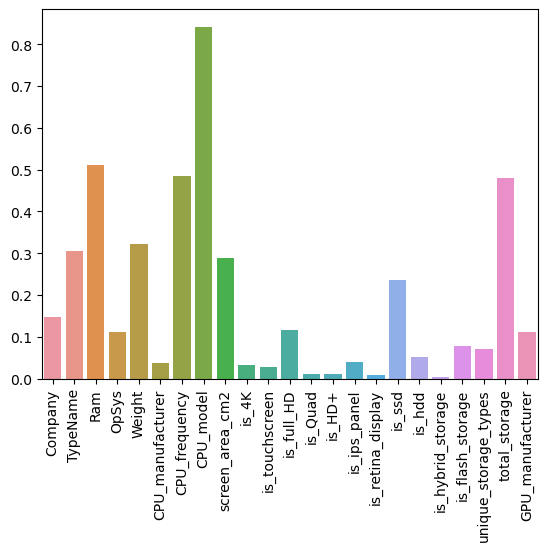

In [17]:
# Mutual Information Score for each feature...
sns.barplot(x = X.columns, y = mi_scores)
plt.xticks(rotation = 90)

In [35]:
# search space of lightgbm regressor
SEARCH_SPACE={
    "n_estimators":scope.int(hp.quniform("n_estimators", 20, 700, 5)),
    "max_depth":scope.int(hp.quniform("max_depth", 1, 12, 1)),
    "min_samples_split":scope.int(hp.quniform("num_leaves", 100, 150, 5)),
    "min_samples_leaf":scope.int(hp.quniform("min_samples_leaf", 30, 500, 20)),
    "min_gain_to_split":scope.float(hp.quniform("min_gain_to_split", 0.1, 15.0, 0.4)),
    "learning_rate":scope.float(hp.quniform("learning_rate", 0.01, 0.3, 0.001)),
    "alpha":hp.loguniform("alpha", -5, -1),
    "random_state":42,
    "categorical_feature":cat_cols_idx
}

In [36]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.15, random_state = 42)

In [37]:
def optimize(params):
    booster = lgbm.LGBMRegressor(**params)
    booster.fit(X_train, y_train,
                eval_set=[(X_valid, y_valid)],
                eval_metric = "rmse",
                early_stopping_rounds = 20)
    y_pred = booster.predict(X_valid)
    rmse = mean_squared_error(y_valid, y_pred, squared=False)
    return {"loss":rmse, "status":STATUS_OK}

In [38]:
best_res = fmin(
    fn = optimize,
    space = SEARCH_SPACE,
    algo = tpe.suggest,
    max_evals=25,
    trials=Trials()
)

[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250
[LightGBM] [Warning] min_gain_to_split is set=14.8, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.8
[LightGBM] [Warning] lambda_l1 is set=0.02490026262121093, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02490026262121093
[LightGBM] [Warning] lambda_l2 is set=0.02943374923479098, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02943374923479098
  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'



[1]	valid_0's rmse: 726.938	valid_0's l2: 528439      
[2]	valid_0's rmse: 706.246	valid_0's l2: 498783      
[3]	valid_0's rmse: 683.711	valid_0's l2: 467461      
[4]	valid_0's rmse: 664.44	valid_0's l2: 441481       
  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'



[5]	valid_0's rmse: 651.735	valid_0's l2: 424759      
[6]	valid_0's rmse: 636.567	valid_0's l2: 405218      
[7]	valid_0's rmse: 621.706	valid_0's l2: 386518      
[8]	valid_0's rmse: 609.097	valid_0's l2: 370999      
[9]	valid_0's rmse: 602.062	valid_0's l2: 362479      
[10]	valid_0's rmse: 593.475	valid_0's l2: 352213     
[11]	valid_0's rmse: 584.839	valid_0's l2: 342036     
[12]	valid_0's rmse: 581.033	valid_0's l2: 337600     
[13]	valid_0's rmse: 574.983	valid_0's l2: 330605     
[14]	valid_0's rmse: 569.738	valid_0's l2: 324602     
[15]	valid_0's rmse: 564.362	valid_0's l2: 318504     
[16]	valid_0's rmse: 560.117	valid_0's l2: 313731     
[17]	valid_0's rmse: 556.044	valid_0's l2: 309185     
[18]	valid_0's rmse: 553.868	valid_0's l2: 306769     
[19]	valid_0's rmse: 552.381	valid_0's l2: 305125     
[20]	valid_0's rmse: 549.054	valid_0's l2: 301461     
[21]	valid_0's rmse: 545.42	valid_0's l2: 297483      
[22]	valid_0's rmse: 543.301	valid_0's l2: 295175     
[23]	valid

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and wil

[4]	valid_0's rmse: 656.063	valid_0's l2: 430419                               
[5]	valid_0's rmse: 641.176	valid_0's l2: 411107                               
[6]	valid_0's rmse: 623.152	valid_0's l2: 388318                               
[7]	valid_0's rmse: 613.599	valid_0's l2: 376503                               
[8]	valid_0's rmse: 606.454	valid_0's l2: 367786                               
[9]	valid_0's rmse: 595.139	valid_0's l2: 354191                               
[10]	valid_0's rmse: 585.947	valid_0's l2: 343334                              
[11]	valid_0's rmse: 581.08	valid_0's l2: 337654                               
[12]	valid_0's rmse: 577.732	valid_0's l2: 333774                              
[13]	valid_0's rmse: 572.009	valid_0's l2: 327194                              
[14]	valid_0's rmse: 569.283	valid_0's l2: 324083                              
[15]	valid_0's rmse: 567.605	valid_0's l2: 322175                              
[16]	valid_0's rmse: 561.084	valid_0's l

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and wil

[4]	valid_0's rmse: 726.696	valid_0's l2: 528087
[5]	valid_0's rmse: 720.678	valid_0's l2: 519377                               
[6]	valid_0's rmse: 715.148	valid_0's l2: 511437                               
[7]	valid_0's rmse: 710.072	valid_0's l2: 504202                               
[8]	valid_0's rmse: 705.416	valid_0's l2: 497612                               
[9]	valid_0's rmse: 701.15	valid_0's l2: 491612                                
[10]	valid_0's rmse: 697.245	valid_0's l2: 486150                              
[11]	valid_0's rmse: 693.672	valid_0's l2: 481181                              
[12]	valid_0's rmse: 690.407	valid_0's l2: 476662                              
[13]	valid_0's rmse: 687.426	valid_0's l2: 472554                              
[14]	valid_0's rmse: 685.617	valid_0's l2: 470071                              
[15]	valid_0's rmse: 682.964	valid_0's l2: 466440                              
[16]	valid_0's rmse: 679.425	valid_0's l2: 461618                      

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'



[1]	valid_0's rmse: 694.815	valid_0's l2: 482767                               
[2]	valid_0's rmse: 650.416	valid_0's l2: 423041                               
[3]	valid_0's rmse: 616.338	valid_0's l2: 379873                               
[4]	valid_0's rmse: 587.256	valid_0's l2: 344869                               
[5]	valid_0's rmse: 567.282	valid_0's l2: 321809                               
[6]	valid_0's rmse: 551.137	valid_0's l2: 303752                               
[7]	valid_0's rmse: 538.02	valid_0's l2: 289466                                
 12%|█▏        | 3/25 [00:25<03:09,  8.61s/trial, best loss: 485.0235090662487]

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'



[8]	valid_0's rmse: 529.037	valid_0's l2: 279880                               
[9]	valid_0's rmse: 524.616	valid_0's l2: 275222                               
[10]	valid_0's rmse: 516.982	valid_0's l2: 267270                              
[11]	valid_0's rmse: 515.091	valid_0's l2: 265319                              
[12]	valid_0's rmse: 510.783	valid_0's l2: 260899                              
[13]	valid_0's rmse: 509.156	valid_0's l2: 259240                              
[14]	valid_0's rmse: 505.887	valid_0's l2: 255922                              
[15]	valid_0's rmse: 502.123	valid_0's l2: 252128                              
[16]	valid_0's rmse: 499.549	valid_0's l2: 249549                              
[17]	valid_0's rmse: 499.144	valid_0's l2: 249145                              
[18]	valid_0's rmse: 496.702	valid_0's l2: 246713                              
[19]	valid_0's rmse: 495.825	valid_0's l2: 245842                              
[20]	valid_0's rmse: 493.381	valid_0's l

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and wil

[7]	valid_0's rmse: 545.955	valid_0's l2: 298067                                
[8]	valid_0's rmse: 537.459	valid_0's l2: 288862                                
[9]	valid_0's rmse: 531.643	valid_0's l2: 282645                                
[10]	valid_0's rmse: 527.377	valid_0's l2: 278127                               
[11]	valid_0's rmse: 522.423	valid_0's l2: 272925                               
[12]	valid_0's rmse: 520.611	valid_0's l2: 271036                               
[13]	valid_0's rmse: 516.014	valid_0's l2: 266271                               
[14]	valid_0's rmse: 515.709	valid_0's l2: 265956                               
[15]	valid_0's rmse: 513.332	valid_0's l2: 263509                               
[16]	valid_0's rmse: 513.111	valid_0's l2: 263283                               
[17]	valid_0's rmse: 512.461	valid_0's l2: 262616                               
[18]	valid_0's rmse: 512.61	valid_0's l2: 262769                                
[19]	valid_0's rmse: 510.477

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and wil

[1]	valid_0's rmse: 736.751	valid_0's l2: 542802                                
[2]	valid_0's rmse: 720.439	valid_0's l2: 519033                                
[3]	valid_0's rmse: 705.171	valid_0's l2: 497265                                
[4]	valid_0's rmse: 694.928	valid_0's l2: 482925                                
[5]	valid_0's rmse: 685.157	valid_0's l2: 469441                                
[6]	valid_0's rmse: 676.686	valid_0's l2: 457904                                
[7]	valid_0's rmse: 665.01	valid_0's l2: 442238                                 
[8]	valid_0's rmse: 656.913	valid_0's l2: 431534                                
[9]	valid_0's rmse: 650.421	valid_0's l2: 423048                                
[10]	valid_0's rmse: 641.037	valid_0's l2: 410929                               
[11]	valid_0's rmse: 634.714	valid_0's l2: 402862                               
[12]	valid_0's rmse: 629.794	valid_0's l2: 396640                               
[13]	valid_0's rmse: 622.274

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and wil

[2]	valid_0's rmse: 622.289	valid_0's l2: 387243                                
[3]	valid_0's rmse: 585.027	valid_0's l2: 342257                                
[4]	valid_0's rmse: 561.325	valid_0's l2: 315086                                
[5]	valid_0's rmse: 541.797	valid_0's l2: 293544                                
[6]	valid_0's rmse: 528.857	valid_0's l2: 279690                                
[7]	valid_0's rmse: 518.531	valid_0's l2: 268874                                
[8]	valid_0's rmse: 510.764	valid_0's l2: 260880                                
[9]	valid_0's rmse: 507.779	valid_0's l2: 257839                                
[10]	valid_0's rmse: 506.466	valid_0's l2: 256508                               
[11]	valid_0's rmse: 502.587	valid_0's l2: 252594                               
[12]	valid_0's rmse: 499.702	valid_0's l2: 249703                               
[13]	valid_0's rmse: 496.557	valid_0's l2: 246569                               
[14]	valid_0's rmse: 494.273

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and wil


[6]	valid_0's rmse: 663.505	valid_0's l2: 440239                                
[7]	valid_0's rmse: 657.541	valid_0's l2: 432360                                
[8]	valid_0's rmse: 655.139	valid_0's l2: 429207                                
[9]	valid_0's rmse: 647.751	valid_0's l2: 419582                                
[10]	valid_0's rmse: 644.57	valid_0's l2: 415470                                
[11]	valid_0's rmse: 643.406	valid_0's l2: 413971                               
[12]	valid_0's rmse: 638.659	valid_0's l2: 407885                               
[13]	valid_0's rmse: 638.405	valid_0's l2: 407562                               
[14]	valid_0's rmse: 634.98	valid_0's l2: 403200                                
[15]	valid_0's rmse: 634.785	valid_0's l2: 402952                               
[16]	valid_0's rmse: 633.806	valid_0's l2: 401710                               
[17]	valid_0's rmse: 631.263	valid_0's l2: 398493                               
[18]	valid_0's rmse: 629.45

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and wil

[2]	valid_0's rmse: 738.34	valid_0's l2: 545147
[3]	valid_0's rmse: 730.441	valid_0's l2: 533545                                
[4]	valid_0's rmse: 723.259	valid_0's l2: 523103                                
[5]	valid_0's rmse: 716.736	valid_0's l2: 513710                                
[6]	valid_0's rmse: 710.819	valid_0's l2: 505263                                
[7]	valid_0's rmse: 705.458	valid_0's l2: 497671                                
[8]	valid_0's rmse: 700.607	valid_0's l2: 490851                                
[9]	valid_0's rmse: 696.223	valid_0's l2: 484726                                
[10]	valid_0's rmse: 692.264	valid_0's l2: 479230                               
[11]	valid_0's rmse: 688.695	valid_0's l2: 474300                               
[12]	valid_0's rmse: 685.479	valid_0's l2: 469882                               
[13]	valid_0's rmse: 683.473	valid_0's l2: 467135                               
[14]	valid_0's rmse: 679.435	valid_0's l2: 461632            

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and wil

[9]	valid_0's rmse: 639.625	valid_0's l2: 409120                                
[10]	valid_0's rmse: 630.238	valid_0's l2: 397200                               
[11]	valid_0's rmse: 622.865	valid_0's l2: 387961                               
[12]	valid_0's rmse: 617.374	valid_0's l2: 381151                               
[13]	valid_0's rmse: 610.308	valid_0's l2: 372476                               
[14]	valid_0's rmse: 604.99	valid_0's l2: 366013                                
[15]	valid_0's rmse: 601.002	valid_0's l2: 361204                               
[16]	valid_0's rmse: 597.583	valid_0's l2: 357105                               
[17]	valid_0's rmse: 592.595	valid_0's l2: 351169                               
[18]	valid_0's rmse: 589.129	valid_0's l2: 347073                               
[19]	valid_0's rmse: 586.69	valid_0's l2: 344205                                
[20]	valid_0's rmse: 582.94	valid_0's l2: 339819                                
[21]	valid_0's rmse: 581.008

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and wil

[6]	valid_0's rmse: 709.449	valid_0's l2: 503318                                 
[7]	valid_0's rmse: 704.012	valid_0's l2: 495633                                 
[8]	valid_0's rmse: 699.113	valid_0's l2: 488760                                 
[9]	valid_0's rmse: 694.706	valid_0's l2: 482617                                 
[10]	valid_0's rmse: 690.746	valid_0's l2: 477131                                
[11]	valid_0's rmse: 687.192	valid_0's l2: 472233                                
[12]	valid_0's rmse: 685.067	valid_0's l2: 469317                                
[13]	valid_0's rmse: 680.822	valid_0's l2: 463519                                
[14]	valid_0's rmse: 677.806	valid_0's l2: 459422                                
[15]	valid_0's rmse: 676.092	valid_0's l2: 457100                                
[16]	valid_0's rmse: 672.393	valid_0's l2: 452112                                
[17]	valid_0's rmse: 669.843	valid_0's l2: 448689                                
[18]	valid_0's r

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and wil

[2]	valid_0's rmse: 688.929	valid_0's l2: 474623                                 
[3]	valid_0's rmse: 661.848	valid_0's l2: 438043                                 
[4]	valid_0's rmse: 639.822	valid_0's l2: 409372                                 
[5]	valid_0's rmse: 620.626	valid_0's l2: 385176                                 
[6]	valid_0's rmse: 604.164	valid_0's l2: 365014                                 
[7]	valid_0's rmse: 591.079	valid_0's l2: 349374                                 
[8]	valid_0's rmse: 577.512	valid_0's l2: 333521                                 
[9]	valid_0's rmse: 566.805	valid_0's l2: 321268                                 
[10]	valid_0's rmse: 558.115	valid_0's l2: 311493                                
[11]	valid_0's rmse: 550.555	valid_0's l2: 303111                                
[12]	valid_0's rmse: 544.21	valid_0's l2: 296165                                 
[13]	valid_0's rmse: 537.99	valid_0's l2: 289433                                 
[14]	valid_0's r

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and wil

[4]	valid_0's rmse: 650.812	valid_0's l2: 423557
[5]	valid_0's rmse: 632.074	valid_0's l2: 399517                                
[6]	valid_0's rmse: 620.614	valid_0's l2: 385162                                
[7]	valid_0's rmse: 605.639	valid_0's l2: 366799                                
[8]	valid_0's rmse: 595.05	valid_0's l2: 354084                                 
[9]	valid_0's rmse: 589.815	valid_0's l2: 347881                                
[10]	valid_0's rmse: 580.701	valid_0's l2: 337213                               
[11]	valid_0's rmse: 577.997	valid_0's l2: 334081                               
[12]	valid_0's rmse: 571.637	valid_0's l2: 326768                               
[13]	valid_0's rmse: 565.048	valid_0's l2: 319280                               
[14]	valid_0's rmse: 560.867	valid_0's l2: 314572                               
[15]	valid_0's rmse: 558.128	valid_0's l2: 311507                               
[16]	valid_0's rmse: 553.794	valid_0's l2: 306688           

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and wil

[4]	valid_0's rmse: 604.447	valid_0's l2: 365356
[5]	valid_0's rmse: 585.402	valid_0's l2: 342696                                
[6]	valid_0's rmse: 569.237	valid_0's l2: 324030                                
[7]	valid_0's rmse: 555.029	valid_0's l2: 308058                                
[8]	valid_0's rmse: 545.37	valid_0's l2: 297428                                 
[9]	valid_0's rmse: 537.254	valid_0's l2: 288641                                
[10]	valid_0's rmse: 529.546	valid_0's l2: 280419                               
[11]	valid_0's rmse: 524.869	valid_0's l2: 275488                               
[12]	valid_0's rmse: 519.913	valid_0's l2: 270309                               
[13]	valid_0's rmse: 514.863	valid_0's l2: 265084                               
[14]	valid_0's rmse: 514.29	valid_0's l2: 264495                                
[15]	valid_0's rmse: 511.142	valid_0's l2: 261266                               
[16]	valid_0's rmse: 509.757	valid_0's l2: 259853           

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and wil

[6]	valid_0's rmse: 725.884	valid_0's l2: 526908                                
[7]	valid_0's rmse: 723.882	valid_0's l2: 524005                                
[8]	valid_0's rmse: 722.058	valid_0's l2: 521368                                
[9]	valid_0's rmse: 721.346	valid_0's l2: 520340                                
[10]	valid_0's rmse: 720.791	valid_0's l2: 519539                               
[11]	valid_0's rmse: 720.898	valid_0's l2: 519694                               
[12]	valid_0's rmse: 720.926	valid_0's l2: 519735                               
[13]	valid_0's rmse: 721.057	valid_0's l2: 519923                               
[14]	valid_0's rmse: 720.853	valid_0's l2: 519629                               
[15]	valid_0's rmse: 720.877	valid_0's l2: 519663                               
[16]	valid_0's rmse: 719.656	valid_0's l2: 517905                               
[17]	valid_0's rmse: 719.755	valid_0's l2: 518048                               
[18]	valid_0's rmse: 718.718

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and wil

[4]	valid_0's rmse: 729.878	valid_0's l2: 532722                                
[5]	valid_0's rmse: 727.817	valid_0's l2: 529718                                
[6]	valid_0's rmse: 725.976	valid_0's l2: 527041                                
[7]	valid_0's rmse: 725.769	valid_0's l2: 526741                                
[8]	valid_0's rmse: 725.714	valid_0's l2: 526661                                
[9]	valid_0's rmse: 725.604	valid_0's l2: 526502                                
[10]	valid_0's rmse: 725.552	valid_0's l2: 526426                               
[11]	valid_0's rmse: 723.491	valid_0's l2: 523439                               
[12]	valid_0's rmse: 723.403	valid_0's l2: 523312                               
[13]	valid_0's rmse: 721.696	valid_0's l2: 520846                               
[14]	valid_0's rmse: 721.722	valid_0's l2: 520883                               
[15]	valid_0's rmse: 722.38	valid_0's l2: 521832                                
[16]	valid_0's rmse: 721.004

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and wil

[5]	valid_0's rmse: 671.552	valid_0's l2: 450982                                
[6]	valid_0's rmse: 661.172	valid_0's l2: 437149                                
[7]	valid_0's rmse: 652.607	valid_0's l2: 425896                                
[8]	valid_0's rmse: 640.429	valid_0's l2: 410149                                
[9]	valid_0's rmse: 632.858	valid_0's l2: 400509                                
[10]	valid_0's rmse: 626.811	valid_0's l2: 392892                               
[11]	valid_0's rmse: 617.579	valid_0's l2: 381404                               
[12]	valid_0's rmse: 612.112	valid_0's l2: 374681                               
[13]	valid_0's rmse: 607.913	valid_0's l2: 369558                               
[14]	valid_0's rmse: 600.926	valid_0's l2: 361112                               
[15]	valid_0's rmse: 597.008	valid_0's l2: 356419                               
[16]	valid_0's rmse: 594.138	valid_0's l2: 353000                               
[17]	valid_0's rmse: 588.455

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'



[1]	valid_0's rmse: 753.003	valid_0's l2: 567014                                
[2]	valid_0's rmse: 750.144	valid_0's l2: 562717                                
[3]	valid_0's rmse: 747.364	valid_0's l2: 558552                                
[4]	valid_0's rmse: 744.659	valid_0's l2: 554517                                
[5]	valid_0's rmse: 742.029	valid_0's l2: 550607                                
[6]	valid_0's rmse: 739.471	valid_0's l2: 546818                                
[7]	valid_0's rmse: 736.985	valid_0's l2: 543147                                


c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'



[8]	valid_0's rmse: 734.568	valid_0's l2: 539590
[9]	valid_0's rmse: 732.218	valid_0's l2: 536143                                
[10]	valid_0's rmse: 729.935	valid_0's l2: 532804                               
[11]	valid_0's rmse: 727.715	valid_0's l2: 529570                               
[12]	valid_0's rmse: 725.559	valid_0's l2: 526436                               
[13]	valid_0's rmse: 723.464	valid_0's l2: 523400                               
[14]	valid_0's rmse: 721.429	valid_0's l2: 520460                               
[15]	valid_0's rmse: 719.452	valid_0's l2: 517611                               
[16]	valid_0's rmse: 717.532	valid_0's l2: 514852                               
[17]	valid_0's rmse: 715.667	valid_0's l2: 512179                               
[18]	valid_0's rmse: 713.856	valid_0's l2: 509591                               
[19]	valid_0's rmse: 712.098	valid_0's l2: 507084                               
[20]	valid_0's rmse: 710.391	valid_0's l2: 504656           

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'



[1]	valid_0's rmse: 698.363	valid_0's l2: 487710                                
[2]	valid_0's rmse: 666.618	valid_0's l2: 444380                                
[3]	valid_0's rmse: 633.909	valid_0's l2: 401840                                
[4]	valid_0's rmse: 605.993	valid_0's l2: 367227                                
[5]	valid_0's rmse: 595.559	valid_0's l2: 354690                                
[6]	valid_0's rmse: 581.33	valid_0's l2: 337945                                 
[7]	valid_0's rmse: 567.367	valid_0's l2: 321905                                
[8]	valid_0's rmse: 560.188	valid_0's l2: 313810                                
[9]	valid_0's rmse: 555.843	valid_0's l2: 308962                                
[10]	valid_0's rmse: 550.106	valid_0's l2: 302617                               
[11]	valid_0's rmse: 544.746	valid_0's l2: 296748                               
[12]	valid_0's rmse: 543.714	valid_0's l2: 295625                               
 72%|███████▏  | 18/25 [02:3

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'



[13]	valid_0's rmse: 539.178	valid_0's l2: 290712                               
[14]	valid_0's rmse: 538.252	valid_0's l2: 289715                               
[15]	valid_0's rmse: 536.811	valid_0's l2: 288166                               
[16]	valid_0's rmse: 535.011	valid_0's l2: 286237                               
[17]	valid_0's rmse: 532.394	valid_0's l2: 283443                               
[18]	valid_0's rmse: 530.797	valid_0's l2: 281745                               
[19]	valid_0's rmse: 529.937	valid_0's l2: 280833                               
[20]	valid_0's rmse: 526.99	valid_0's l2: 277719                                
[21]	valid_0's rmse: 525.496	valid_0's l2: 276146                               
[22]	valid_0's rmse: 523.61	valid_0's l2: 274168                                
[23]	valid_0's rmse: 521.372	valid_0's l2: 271829                               
[24]	valid_0's rmse: 520.86	valid_0's l2: 271295                                
[25]	valid_0's rmse: 519.678

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and wil

[6]	valid_0's rmse: 615.555	valid_0's l2: 378907                                
[7]	valid_0's rmse: 602.754	valid_0's l2: 363313                                
[8]	valid_0's rmse: 589.835	valid_0's l2: 347905                                
[9]	valid_0's rmse: 580.348	valid_0's l2: 336803                                
[10]	valid_0's rmse: 571.552	valid_0's l2: 326671                               
[11]	valid_0's rmse: 565.29	valid_0's l2: 319553                                
[12]	valid_0's rmse: 560.012	valid_0's l2: 313613                               
[13]	valid_0's rmse: 554.565	valid_0's l2: 307543                               
[14]	valid_0's rmse: 548.982	valid_0's l2: 301381                               
[15]	valid_0's rmse: 546.754	valid_0's l2: 298940                               
[16]	valid_0's rmse: 543.071	valid_0's l2: 294927                               
[17]	valid_0's rmse: 539.373	valid_0's l2: 290923                               
[18]	valid_0's rmse: 538.24	

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'



[1]	valid_0's rmse: 687.705	valid_0's l2: 472939                                
[2]	valid_0's rmse: 635.629	valid_0's l2: 404024                                
[3]	valid_0's rmse: 594.094	valid_0's l2: 352948                                
[4]	valid_0's rmse: 564.527	valid_0's l2: 318691                                
[5]	valid_0's rmse: 541.656	valid_0's l2: 293392                                
[6]	valid_0's rmse: 524.423	valid_0's l2: 275019                                
 80%|████████  | 20/25 [02:58<00:41,  8.28s/trial, best loss: 376.2364006427174]

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'



[7]	valid_0's rmse: 507.91	valid_0's l2: 257972                                 
[8]	valid_0's rmse: 492.786	valid_0's l2: 242838                                
[9]	valid_0's rmse: 482.906	valid_0's l2: 233198                                
[10]	valid_0's rmse: 474.196	valid_0's l2: 224862                               
[11]	valid_0's rmse: 465.961	valid_0's l2: 217120                               
[12]	valid_0's rmse: 460.799	valid_0's l2: 212336                               
[13]	valid_0's rmse: 455.479	valid_0's l2: 207461                               
[14]	valid_0's rmse: 451.589	valid_0's l2: 203932                               
[15]	valid_0's rmse: 450.139	valid_0's l2: 202625                               
[16]	valid_0's rmse: 447.391	valid_0's l2: 200159                               
[17]	valid_0's rmse: 444.82	valid_0's l2: 197864                                
[18]	valid_0's rmse: 440.918	valid_0's l2: 194408                               
[19]	valid_0's rmse: 439.31	

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and wil

[3]	valid_0's rmse: 590.613	valid_0's l2: 348824                                 
[4]	valid_0's rmse: 561.121	valid_0's l2: 314857                                 
[5]	valid_0's rmse: 538.465	valid_0's l2: 289945                                 
[6]	valid_0's rmse: 516.877	valid_0's l2: 267162                                 
[7]	valid_0's rmse: 499.731	valid_0's l2: 249732                                 
[8]	valid_0's rmse: 487.866	valid_0's l2: 238013                                 
[9]	valid_0's rmse: 476.979	valid_0's l2: 227509                                 
[10]	valid_0's rmse: 470.903	valid_0's l2: 221750                                
[11]	valid_0's rmse: 464.082	valid_0's l2: 215372                                
[12]	valid_0's rmse: 461.534	valid_0's l2: 213014                                
[13]	valid_0's rmse: 455.666	valid_0's l2: 207632                                
[14]	valid_0's rmse: 451.971	valid_0's l2: 204278                                
[15]	valid_0's r

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and wil

[8]	valid_0's rmse: 489.641	valid_0's l2: 239748                                 
[9]	valid_0's rmse: 478.559	valid_0's l2: 229018                                 
[10]	valid_0's rmse: 472.328	valid_0's l2: 223094                                
[11]	valid_0's rmse: 465.391	valid_0's l2: 216589                                
[12]	valid_0's rmse: 462.56	valid_0's l2: 213962                                 
[13]	valid_0's rmse: 459.18	valid_0's l2: 210846                                 
[14]	valid_0's rmse: 455.571	valid_0's l2: 207545                                
[15]	valid_0's rmse: 453.02	valid_0's l2: 205227                                 
[16]	valid_0's rmse: 450.356	valid_0's l2: 202821                                
[17]	valid_0's rmse: 447.185	valid_0's l2: 199974                                
[18]	valid_0's rmse: 444.837	valid_0's l2: 197880                                
[19]	valid_0's rmse: 442.116	valid_0's l2: 195467                                
[20]	valid_0's r

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and wil

[5]	valid_0's rmse: 505.941	valid_0's l2: 255976                                 
[6]	valid_0's rmse: 485.49	valid_0's l2: 235700                                  
[7]	valid_0's rmse: 473.794	valid_0's l2: 224481                                 
[8]	valid_0's rmse: 464.963	valid_0's l2: 216190                                 
[9]	valid_0's rmse: 461.687	valid_0's l2: 213155                                 
[10]	valid_0's rmse: 455.082	valid_0's l2: 207100                                
[11]	valid_0's rmse: 449.633	valid_0's l2: 202169                                
[12]	valid_0's rmse: 446.699	valid_0's l2: 199540                                
[13]	valid_0's rmse: 443.438	valid_0's l2: 196637                                
[14]	valid_0's rmse: 439.642	valid_0's l2: 193285                                
[15]	valid_0's rmse: 438.713	valid_0's l2: 192469                                
[16]	valid_0's rmse: 435.833	valid_0's l2: 189950                                
[17]	valid_0's r

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'



[1]	valid_0's rmse: 668.743	valid_0's l2: 447217                                 
[2]	valid_0's rmse: 611.734	valid_0's l2: 374219                                 
 96%|█████████▌| 24/25 [03:37<00:08,  8.92s/trial, best loss: 330.26902810769434]

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'



[3]	valid_0's rmse: 571.423	valid_0's l2: 326525                                 
[4]	valid_0's rmse: 541.614	valid_0's l2: 293345                                 
[5]	valid_0's rmse: 520.26	valid_0's l2: 270671                                  
[6]	valid_0's rmse: 508.179	valid_0's l2: 258246                                 
[7]	valid_0's rmse: 501.18	valid_0's l2: 251182                                  
[8]	valid_0's rmse: 494.158	valid_0's l2: 244192                                 
[9]	valid_0's rmse: 488.899	valid_0's l2: 239022                                 
[10]	valid_0's rmse: 487.295	valid_0's l2: 237457                                
[11]	valid_0's rmse: 482.854	valid_0's l2: 233148                                
[12]	valid_0's rmse: 476.887	valid_0's l2: 227421                                
[13]	valid_0's rmse: 474.734	valid_0's l2: 225373                                
[14]	valid_0's rmse: 470.451	valid_0's l2: 221324                                
[15]	valid_0's r

In [39]:
best_res

{'learning_rate': 0.26,
 'max_depth': 11.0,
 'min_data_in_leaf': 100.0,
 'min_gain_to_split': 0.4,
 'n_estimators': 275.0,
 'num_leaves': 40.0,
 'reg_alpha': 0.32971472100585403,
 'reg_lambda': 0.01609554391480798}

In [40]:
params = {'learning_rate': 0.26,
 'max_depth': 11,
 'min_data_in_leaf': 100,
 'min_gain_to_split': 0.4,
 'n_estimators': 275,
 'num_leaves': 40,
 'reg_alpha': 0.32971472100585403,
 'reg_lambda': 0.01609554391480798}

In [42]:
cat_preprocessor = Pipeline(steps = [
    ("ordinal-enc", OrdinalEncoder())
])
preprocessor = ColumnTransformer(transformers = [
    ("cat", cat_preprocessor, cat_idx),
    ("other", "passthrough", [2, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21])
], remainder="passthrough")
model_pipeline = Pipeline(steps = [
    ("preprocessor", preprocessor),
    ("missing_handler", SimpleImputer(strategy='constant', fill_value=-1)),
    ("lgbm", lgbm.LGBMRegressor(**params))
])

In [43]:
X = df.drop("Price_euros", axis = 1)
y = df["Price_euros"]

In [44]:
model_pipeline.fit(X, y)

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_gain_to_split is set=0.4, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('ordinal-enc',
                                                                   OrdinalEncoder())]),
                                                  [0, 1, 3, 5, 7, 22]),
                                                 ('other', 'passthrough',
                                                  [2, 4, 6, 8, 9, 10, 11, 12,
                                                   13, 14, 15, 16, 17, 18, 19,
                                                   20, 21])])),
                ('missing_handler',
                 SimpleImputer(fill_value=-1, strategy='constant')),
                ('lgbm',
                 LGBMRegressor(learning_rate=0.26, max_depth=11,
                               min_data_in_leaf=100, min_gain_to_split=0.4,
                               n_estimators=275, num_leaves=40,
                               reg_alpha=0.32971472100585403,
                               reg_lambda=0.01609554391480798))])

In [45]:
mean_squared_error(y, model_pipeline.predict(X), squared = False)

216.30872769665046

In [46]:
with open(os.path.join(os.path.pardir, "app", "bin", "model-pipeline.pkl"), "wb") as pkl:
    pickle.dump(model_pipeline, pkl)